In [1]:
# Imports
import importlib
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../_shared_packages')
import process_cl2_logfile as process_cl2#This underline is unavoidable
importlib.reload(process_cl2)

# Load the file... (path,exp_name,ftir_path)
info = (('data/09_27_humidity_sweep_log.csv','09-27-24 Humidity Sweep (10-60%)','data/09-27_ftir.prn'),
        ('data/09_28_cl2_sweeps_log.csv','09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4','data/09-28_ftir.prn'),
        ('data/09_28_cl2_sweeps_log.csv','09-28-24 Vary Cl2 and CH4 1-to-1 (45-90 ppm)','data/09-28_ftir.prn'),
        ('data/09-30_ch4_sweep_log.csv','09-30-24 Sweep CH4 (10-90 ppm)','data/09-30_ftir_1.prn'),
        ('data/10-01-24_toluene.csv','10-01-24 Sweep Toluene','data/10-01_ftir.prn'),
        ('data/10-02_NO_test.csv','10-02-24 Add NO','data/10-02_ftir.prn'),
        ('data/10-03_nh3_sweep.csv','10-03-24 Sweep NH3','data/10-03_ftir.prn'),
        ('data/10-18_3xCl2_humidity_sweep_log.csv','10-18-24 3x Cl2 and Humidity Sweep','data/10-18_ftir.prn'),
        ('data/10-22_3xCl2_dry_log.csv','10-22-24 3x Cl2 Dry','data/10-22_ftir.prn'),
        )
hush=True
raw_data = process_cl2.extract_data([i[:2] for i in info],hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)
for i in info:
    if len(i)>2:
        (path,exp_name,ftir_path)=i
        process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.

# Suppress a printout
pass

/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/09-29 Cl2 Campaign Redo 1/../_shared_packages/process_cl2_logfile.py:20: DtypeWarning: Columns (38,46,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}


<h1> Loading, trimming, and re-binding log files </h1>

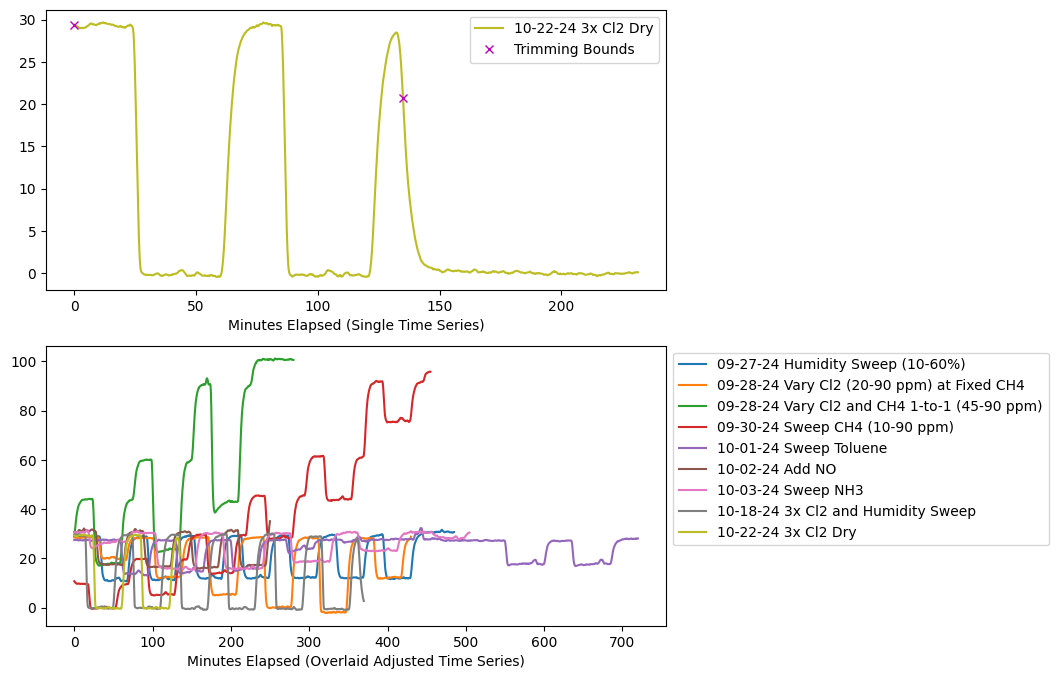

In [2]:
#@np.vectorize
def subtract_cl2_baseline(mv):
    return (mv-43.5) # This baseline stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup

importlib.reload(process_cl2)
trim_params=((15,500),
             (10,440),
             (440,720),
             (165,620),
             (100,820),
             (20,270),
             (10,515),
             (0,370),
             (0,135),
             )
(data,ax1,ax2) = process_cl2.trim_dataframes(raw_data,trim_params,
                                   plot=True,which_field='FTIR: CH4 (ppm)',which_df=8)
rf = process_cl2.RemovalFinder(data,"09-29_cl2_campaign_after_mfc_zero")

<h1> Humidity Sweep 9-27 </h1>

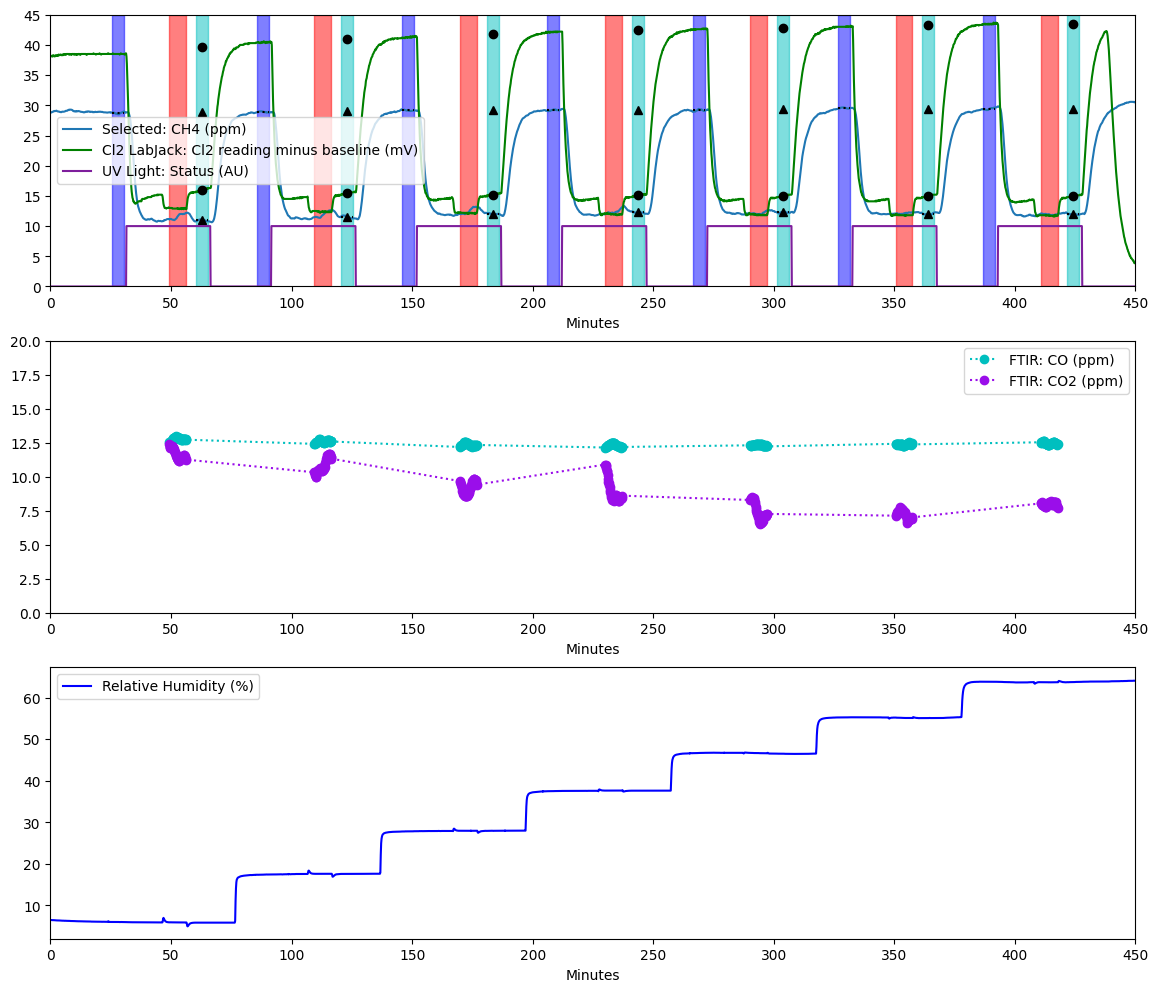

In [3]:
importlib.reload(process_cl2)

current_experiment = '09-27-24 Humidity Sweep (10-60%)'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,500)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the RH
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['Humidity Probe: Rel. Humidity (%)']*(1.0/(1-6.0/200.0)),
        label='Relative Humidity (%)',color='b')
axs[2].set_xlim(0,450)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

<h1> Sweep Cl2 at Fixed CH4 9-28 </h2>

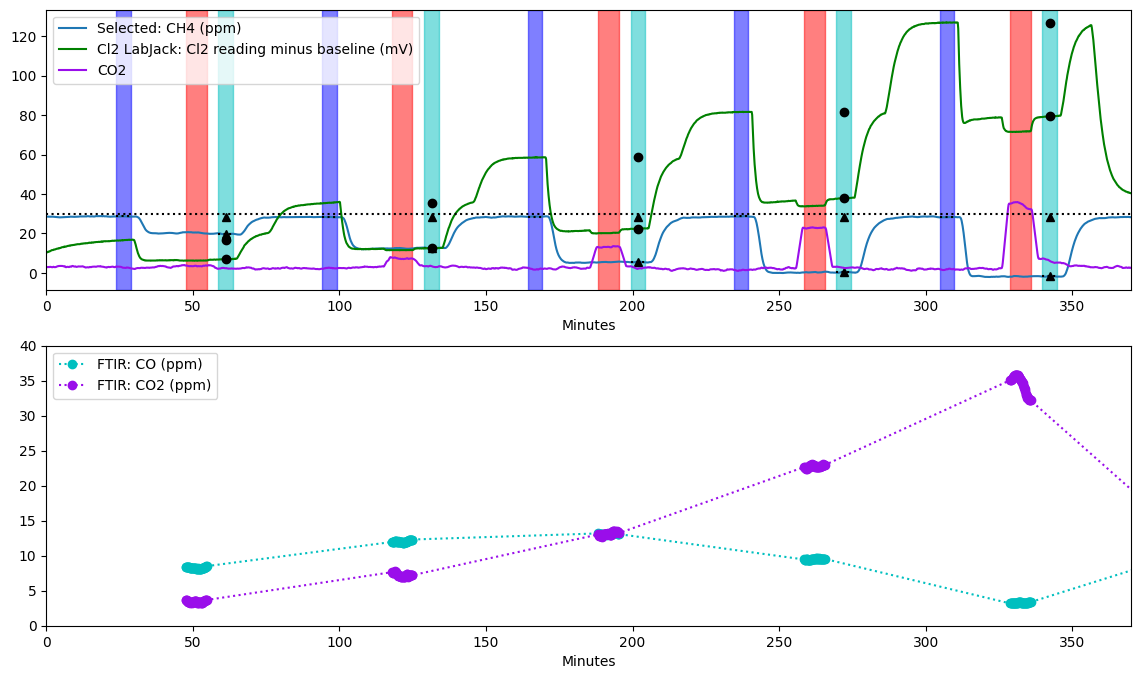

In [4]:
importlib.reload(process_cl2)
current_experiment = '09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet',label='CO2')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,370)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,40)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


<h1>Sweep CH4 and Cl2 in 1:1 ratio</h1>

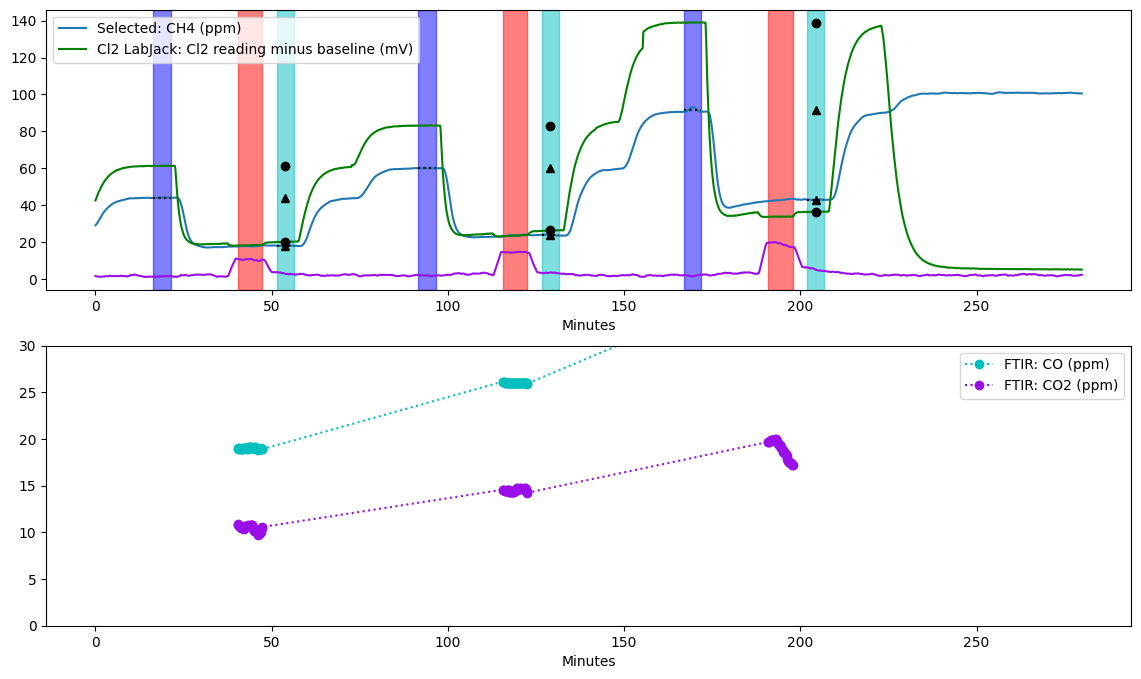

In [5]:
importlib.reload(process_cl2)
current_experiment = '09-28-24 Vary Cl2 and CH4 1-to-1 (45-90 ppm)'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] =  subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,30)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass

<h1>Sweep CH4 for fixed Cl2</h1>

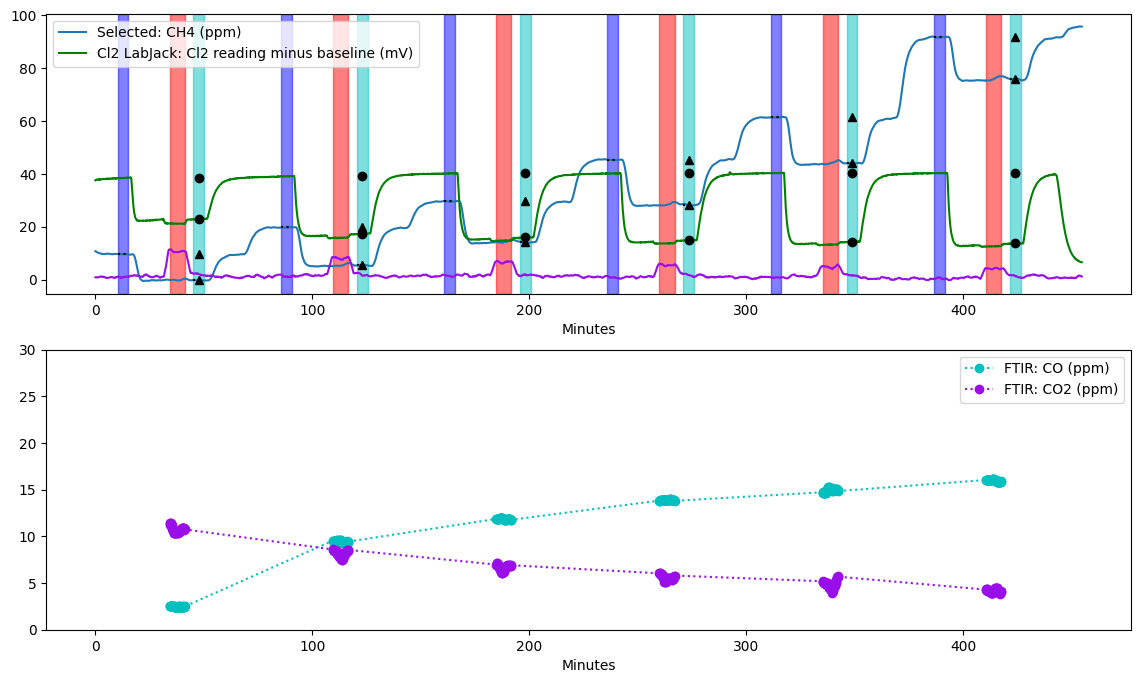

In [6]:
importlib.reload(process_cl2)
current_experiment = '09-30-24 Sweep CH4 (10-90 ppm)'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] =  subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=2,figsize=(14,8),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=570,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'],color='xkcd:violet')

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,30)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

pass

<h1>Sweep toluene for 30 ppm CH4 and Cl2</h1>

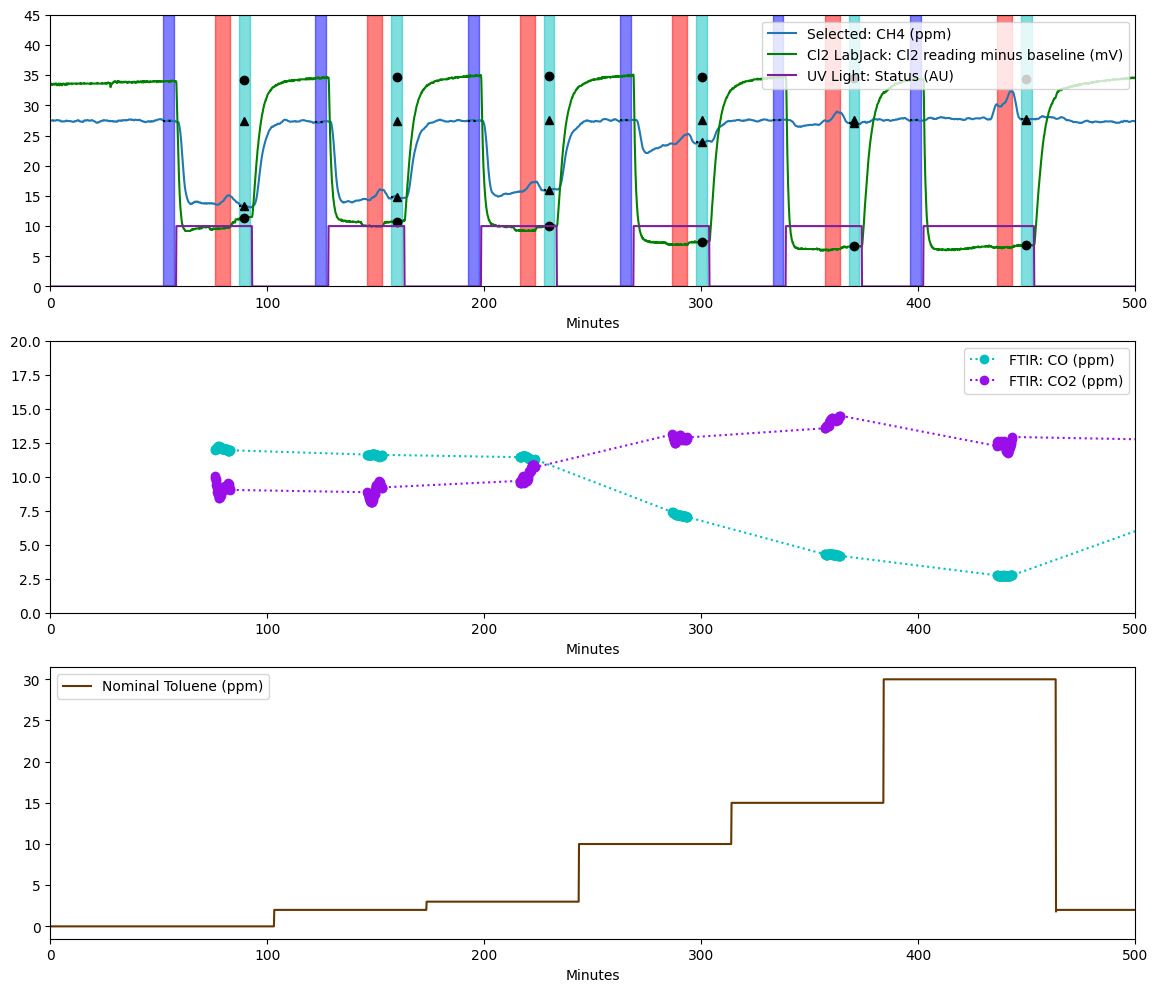

In [7]:
importlib.reload(process_cl2)

current_experiment = '10-01-24 Sweep Toluene'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,500)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the toluene
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['LF N2 MFC: Actual Flow']*(100.0/200.0),
        label='Nominal Toluene (ppm)',color='xkcd:brown')
axs[2].set_xlim(0,500)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

<h1>Add NO to 30ppm CH4 and Cl2</h1>

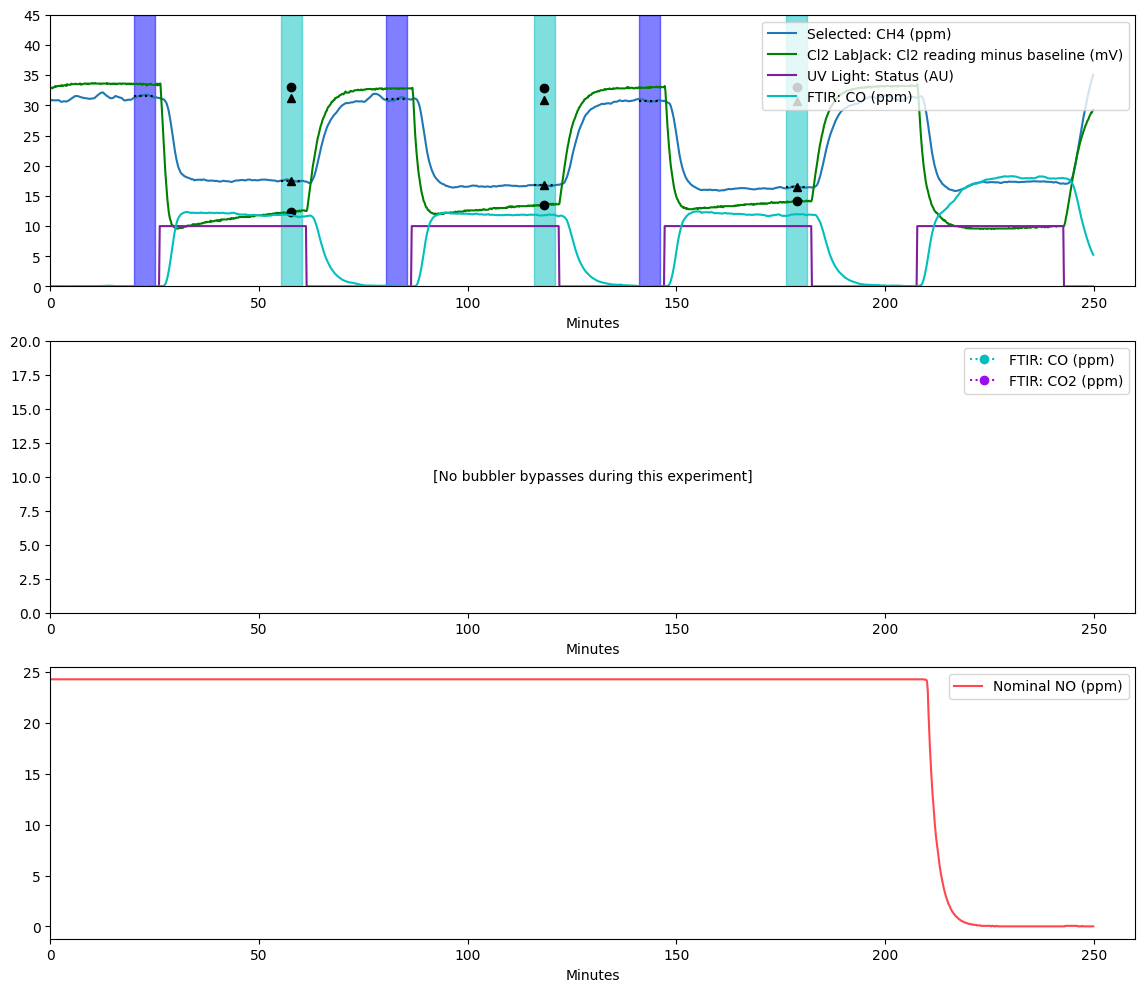

In [8]:
importlib.reload(process_cl2)

current_experiment = '10-02-24 Add NO'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=200,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=200,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].plot(data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO (ppm)'],color='c',label='FTIR: CO (ppm)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,500)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")
axs[1].text(0.5,0.5,"[No bubbler bypasses during this experiment]",ha='center',va='center',transform=axs[1].transAxes)

# Throw in a plot of the toluene
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['LF N2 MFC: Actual Flow']*(100.0/200.0),
        label='Nominal NO (ppm)',color='xkcd:light red')
axs[2].set_xlim(0,260)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

<h1>Sweep NH3 for 30 ppm CH4 and Cl2</h1>

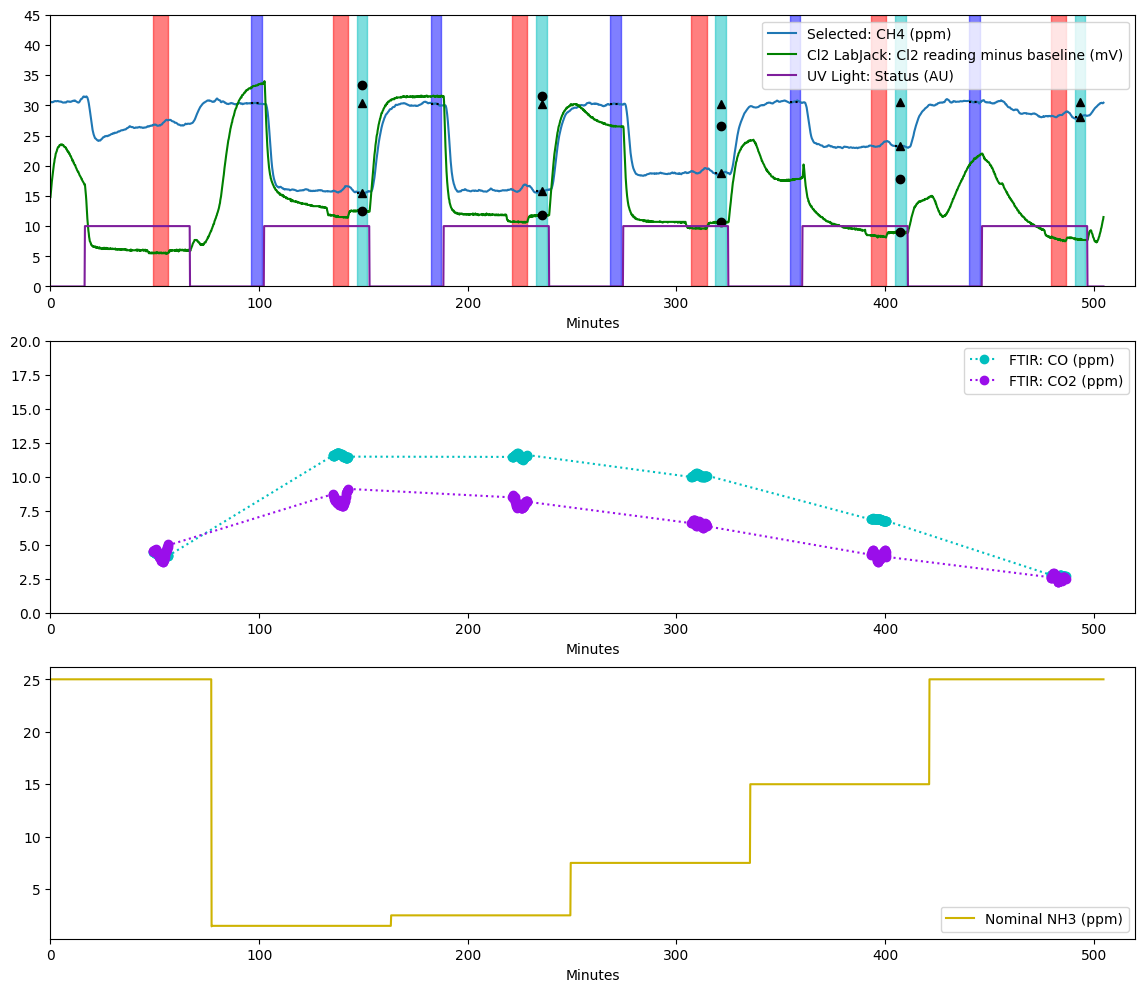

In [9]:
importlib.reload(process_cl2)

current_experiment = '10-03-24 Sweep NH3'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=80,end_time=550,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=80,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,520)
axs[0].set_ylim(0,45)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,20)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the toluene
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['LF N2 MFC: Actual Flow']*(100.0/200.0),
        label='Nominal NH3 (ppm)',color='xkcd:mustard')
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

<h1>10/18 3x Cl2 humidity sweep<h1>

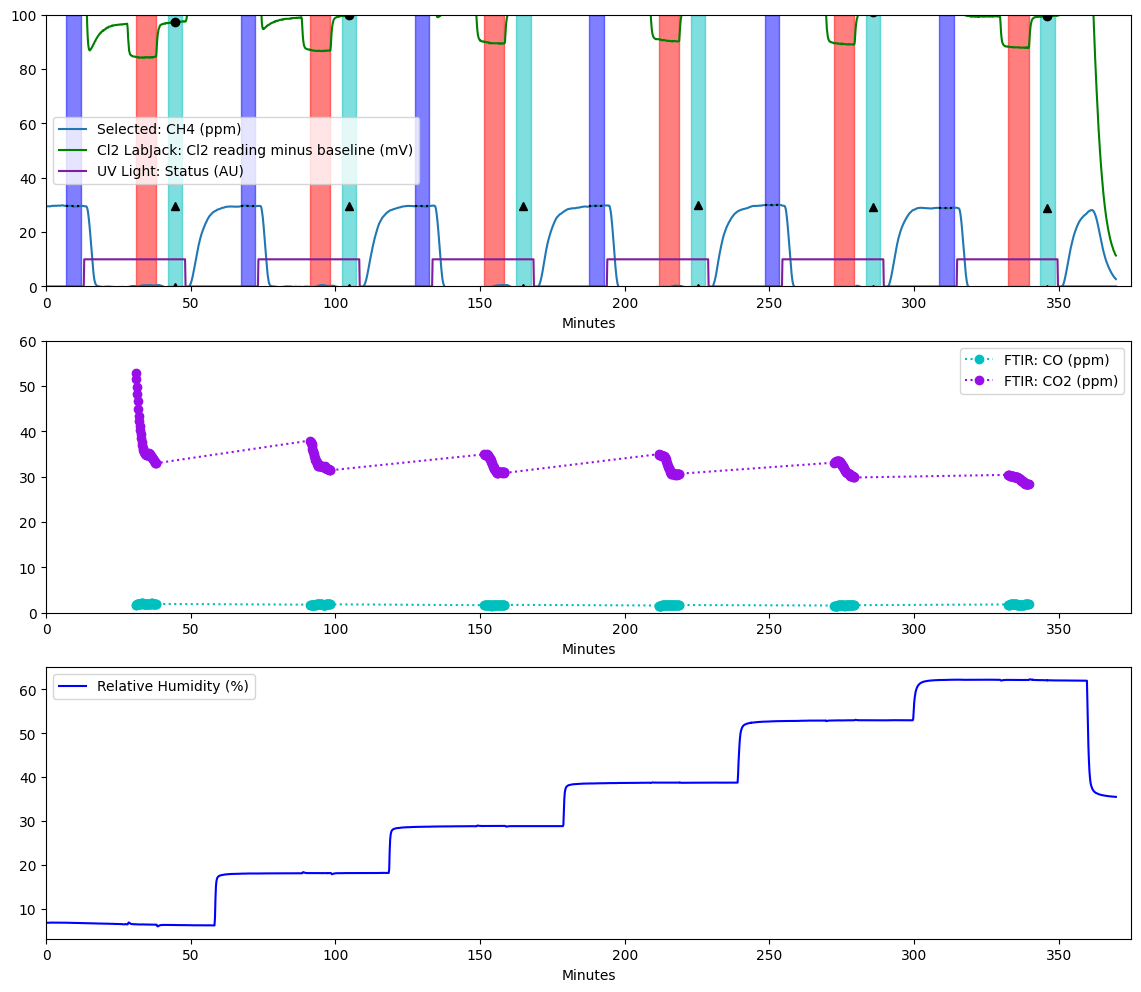

In [10]:
importlib.reload(process_cl2)

current_experiment = '10-18-24 3x Cl2 and Humidity Sweep'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,375)
axs[0].set_ylim(0,100)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,60)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the RH
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['Humidity Probe: Rel. Humidity (%)']*(1.0/(1-6.0/200.0)),
        label='Relative Humidity (%)',color='b')
axs[2].set_xlim(0,375)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

<h1>10/22 3x Cl2 dry (0.1% H2O)<h1>

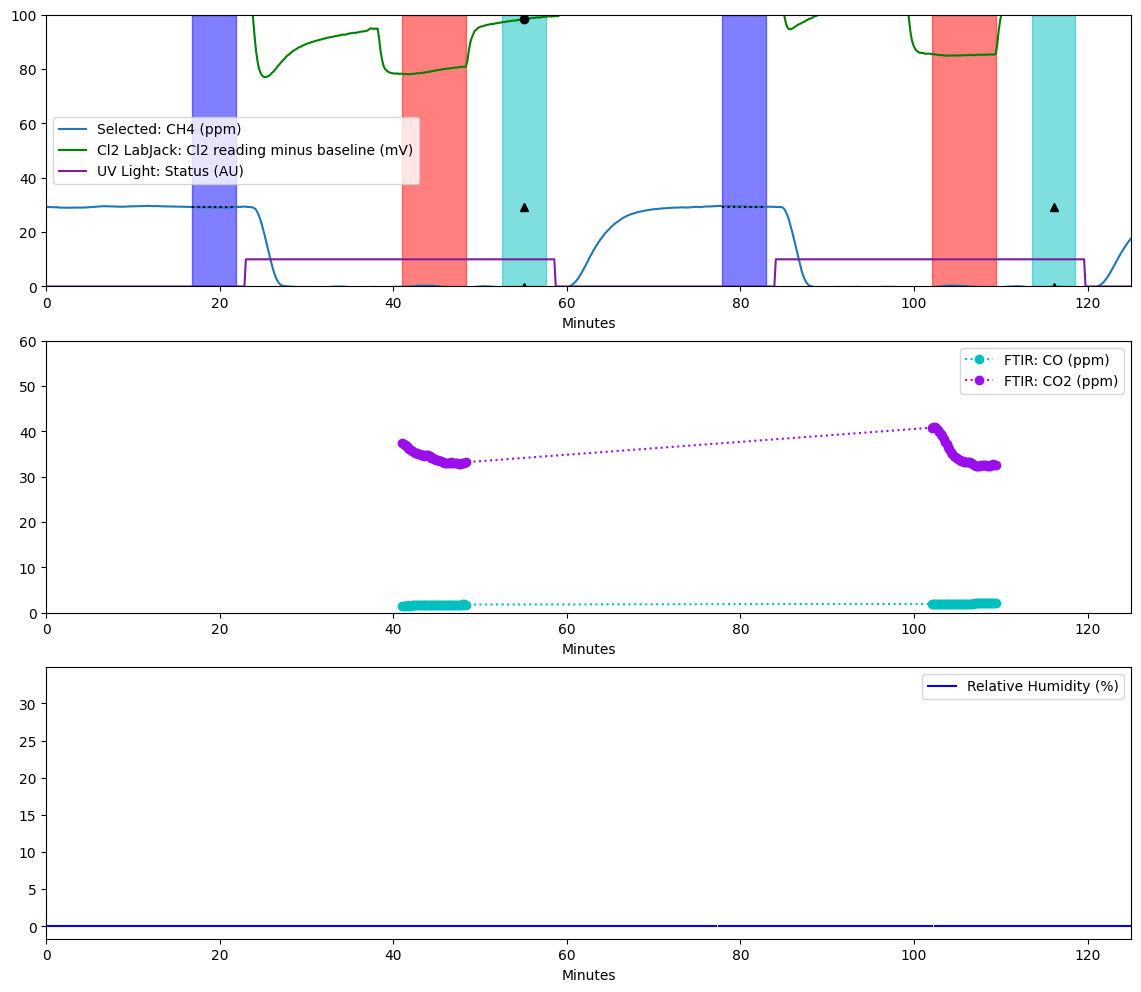

In [11]:
importlib.reload(process_cl2)

current_experiment = '10-22-24 3x Cl2 Dry'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = subtract_cl2_baseline(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']

# Prep the plot region
(fig, axs) = plt.subplots(nrows=3,figsize=(14,12),sharex=True)

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the CH4
rf.set_setup_values(which_field='Selected: CH4 (ppm)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Selected: CH4 (ppm)',color='C0',ax=axs[0],marker='^',do_shading=True)
# Get the Cl2 data
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=True)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,125)
axs[0].set_ylim(0,100)

# Throw in a plot of some of the bypass values
rf.plot_fields_during_bypass(current_experiment,
                                  ['FTIR: CO (ppm)','FTIR: CO2 (ppm)'],
                                  ['c','xkcd:violet'],
                                  ':','o',
                                  axs[1])
axs[1].set_ylim(0,60)
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_xlabel("Minutes")

# Throw in a plot of the RH
axs[2].plot(data[current_experiment]['Minutes'],data[current_experiment]['Humidity Probe: Rel. Humidity (%)']*(1.0/(1-6.0/200.0)),
        label='Relative Humidity (%)',color='b')
axs[2].set_xlim(0,125)
axs[2].set_xlabel("Minutes")
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].legend()

pass

In [12]:
rf.export_conversion_results_to_csv('../_exported_data/')
rf.export_bypass_periods('../_exported_data/')